LSTM 기반 모델 변경 및 개선사항 적용 예시 코드 (상당 부분 gpt가 도와줌)

In [13]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import torch.onnx

import glob
from tqdm import tqdm

import matplotlib.pyplot as plt

from LSTMModel import LSTMModel

import os
import random


In [14]:
# 하이퍼파라미터
TIME_STEP = 10  # 시퀀스 길이
STRIDE = 1
INPUT_SIZE = 9   # 기존의 INPUT_DIM과 일치하도록 수정 (예: 9)
OUTPUT_SIZE = 3  # 기존의 OUTPUT_DIM과 일치하도록 수정 (예: 3)
BATCH_SIZE = 64
HIDDEN_LAYER_SIZE = 128
EPOCHS = 200
LEARNING_RATE = 1e-3
PATIENCE = 20  # Early Stopping을 위한 patience

# 경로 설정
OUTPUT_FILENAME = 'model/improved_lstm_model.pth'
ONNX_PATH = "model/improved_lstm_model.onnx"
DATA_PATH = 'data'
FILE_PATH = "data/data0.csv"  # 실제 데이터 경로에 맞게 수정

# 재현성 확보
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# CUDA 사용 가능 여부 확인
cuda_available = torch.cuda.is_available()
print("CUDA Available?", cuda_available)

CUDA Available? True


In [15]:
# 데이터 로드 및 전처리

# 입력 및 출력 feature 인덱스 정의 (예: 0-8 입력, 9-11 출력)
x_features_csv = list(range(9))  # 0 ~ 8
y_features_csv = list(range(9, 12))  # 9 ~ 11

# 데이터 로드
data = pd.read_csv(FILE_PATH)

# 입력 및 출력 데이터 추출
input_features = data.values[:, x_features_csv]  # (N, 9)
output_features = data.values[:, y_features_csv]  # (N, 3)

# 정규화
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

input_features_scaled = scaler_x.fit_transform(input_features)
output_features_scaled = scaler_y.fit_transform(output_features)


# 시퀀스 데이터 생성
def create_sequences(X, y, time_steps, stride=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, stride):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)


X_seq, y_seq = create_sequences(input_features_scaled, output_features_scaled, TIME_STEP, STRIDE)
print("X_seq shape:", X_seq.shape)  # (N - time_steps, time_steps, input_size)
print("y_seq shape:", y_seq.shape)  # (N - time_steps, output_size)

# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X_seq, y_seq, test_size=0.1, random_state=SEED)

# Tensor로 변환
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

# DataLoader 생성
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f'Training samples: {len(train_loader.dataset)}')
print(f'Validation samples: {len(val_loader.dataset)}')

X_seq shape: (7723, 10, 9)
y_seq shape: (7723, 3)
Training samples: 6950
Validation samples: 773


In [16]:
# 모델 정의

model = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_size=OUTPUT_SIZE, dropout=0.3)

# GPU 사용 설정
if cuda_available:
    model.cuda()

# 손실 함수 및 옵티마이저 정의
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning Rate Scheduler (학습률 감소)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                       factor=0.5, patience=10,
                                                       verbose=True)

# Early Stopping 변수 초기화
best_val_rmse = float('inf')
es_counter = 0
early_stop = False


C:\Users\dot_mario\anaconda3\envs\KartML_Python\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [17]:
# 학습 루프

for epoch in range(1, EPOCHS + 1):
    # Training
    model.train()
    train_losses = []
    for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} Training"):
        if cuda_available:
            X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_losses.append(loss.item())

    # Validation
    if epoch % 5 == 0 or epoch == EPOCHS:
        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_val_batch, y_val_batch in tqdm(val_loader, desc=f"Epoch {epoch}/{EPOCHS} Validation"):
                if cuda_available:
                    X_val_batch, y_val_batch = X_val_batch.cuda(), y_val_batch.cuda()

                y_val_pred = model(X_val_batch)
                val_loss = criterion(y_val_pred, y_val_batch)
                val_losses.append(val_loss.item())

        train_rmse = np.sqrt(np.mean(train_losses))
        val_rmse = np.sqrt(np.mean(val_losses))
        print(f"Epoch {epoch}, Train RMSE: {train_rmse:.4f}, Val RMSE: {val_rmse:.4f}")

        # Learning Rate Scheduler 업데이트
        scheduler.step(val_rmse)

        # Early Stopping 체크
        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            print(f"New best model with RMSE: {best_val_rmse:.4f}, saving model...")
            torch.save(model.state_dict(), OUTPUT_FILENAME)
            es_counter = 0
        else:
            es_counter += 1
            print(f"Validation RMSE did not improve. Patience counter: {es_counter}/{PATIENCE}")
            if es_counter >= PATIENCE:
                print("Early stopping triggered. Ending training.")
                early_stop = True
                break

    if early_stop:
        break

# Load best model
model.load_state_dict(torch.load(OUTPUT_FILENAME))

Epoch 5/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1126.80it/s]


Epoch 5, Train RMSE: 0.0804, Val RMSE: 0.0612
New best model with RMSE: 0.0612, saving model...


Epoch 10/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1124.78it/s]


Epoch 10, Train RMSE: 0.0661, Val RMSE: 0.0535
New best model with RMSE: 0.0535, saving model...


Epoch 15/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1037.58it/s]


Epoch 15, Train RMSE: 0.0619, Val RMSE: 0.0507
New best model with RMSE: 0.0507, saving model...


Epoch 20/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 960.52it/s]


Epoch 20, Train RMSE: 0.0564, Val RMSE: 0.0490
New best model with RMSE: 0.0490, saving model...


Epoch 25/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1004.09it/s]


Epoch 25, Train RMSE: 0.0534, Val RMSE: 0.0485
New best model with RMSE: 0.0485, saving model...


Epoch 30/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1219.55it/s]


Epoch 30, Train RMSE: 0.0521, Val RMSE: 0.0469
New best model with RMSE: 0.0469, saving model...


Epoch 35/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 850.02it/s]


Epoch 35, Train RMSE: 0.0503, Val RMSE: 0.0458
New best model with RMSE: 0.0458, saving model...


Epoch 40/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1129.00it/s]


Epoch 40, Train RMSE: 0.0498, Val RMSE: 0.0450
New best model with RMSE: 0.0450, saving model...


Epoch 45/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1080.02it/s]


Epoch 45, Train RMSE: 0.0492, Val RMSE: 0.0417
New best model with RMSE: 0.0417, saving model...


Epoch 50/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 996.62it/s]


Epoch 50, Train RMSE: 0.0487, Val RMSE: 0.0398
New best model with RMSE: 0.0398, saving model...


Epoch 55/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1037.44it/s]


Epoch 55, Train RMSE: 0.0486, Val RMSE: 0.0405
Validation RMSE did not improve. Patience counter: 1/20


Epoch 60/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1364.07it/s]


Epoch 60, Train RMSE: 0.0480, Val RMSE: 0.0416
Validation RMSE did not improve. Patience counter: 2/20


Epoch 65/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1364.00it/s]


Epoch 65, Train RMSE: 0.0479, Val RMSE: 0.0388
New best model with RMSE: 0.0388, saving model...


Epoch 70/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1234.79it/s]


Epoch 70, Train RMSE: 0.0471, Val RMSE: 0.0396
Validation RMSE did not improve. Patience counter: 1/20


Epoch 75/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1290.49it/s]


Epoch 75, Train RMSE: 0.0469, Val RMSE: 0.0370
New best model with RMSE: 0.0370, saving model...


Epoch 80/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1066.06it/s]


Epoch 80, Train RMSE: 0.0469, Val RMSE: 0.0438
Validation RMSE did not improve. Patience counter: 1/20


Epoch 85/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1228.03it/s]


Epoch 85, Train RMSE: 0.0472, Val RMSE: 0.0434
Validation RMSE did not improve. Patience counter: 2/20


Epoch 90/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1236.36it/s]


Epoch 90, Train RMSE: 0.0460, Val RMSE: 0.0374
Validation RMSE did not improve. Patience counter: 3/20


Epoch 95/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1234.51it/s]


Epoch 95, Train RMSE: 0.0459, Val RMSE: 0.0372
Validation RMSE did not improve. Patience counter: 4/20


Epoch 100/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1234.32it/s]


Epoch 100, Train RMSE: 0.0452, Val RMSE: 0.0342
New best model with RMSE: 0.0342, saving model...


Epoch 105/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1233.73it/s]


Epoch 105, Train RMSE: 0.0464, Val RMSE: 0.0354
Validation RMSE did not improve. Patience counter: 1/20


Epoch 110/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1237.68it/s]


Epoch 110, Train RMSE: 0.0455, Val RMSE: 0.0372
Validation RMSE did not improve. Patience counter: 2/20


Epoch 115/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1292.18it/s]


Epoch 115, Train RMSE: 0.0440, Val RMSE: 0.0339
New best model with RMSE: 0.0339, saving model...


Epoch 120/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 877.75it/s]


Epoch 120, Train RMSE: 0.0452, Val RMSE: 0.0353
Validation RMSE did not improve. Patience counter: 1/20


Epoch 125/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1368.59it/s]


Epoch 125, Train RMSE: 0.0456, Val RMSE: 0.0344
Validation RMSE did not improve. Patience counter: 2/20


Epoch 130/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1129.11it/s]


Epoch 130, Train RMSE: 0.0451, Val RMSE: 0.0364
Validation RMSE did not improve. Patience counter: 3/20


Epoch 135/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1128.43it/s]


Epoch 135, Train RMSE: 0.0435, Val RMSE: 0.0341
Validation RMSE did not improve. Patience counter: 4/20


Epoch 140/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1235.02it/s]


Epoch 140, Train RMSE: 0.0444, Val RMSE: 0.0373
Validation RMSE did not improve. Patience counter: 5/20


Epoch 145/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1120.96it/s]


Epoch 145, Train RMSE: 0.0429, Val RMSE: 0.0336
New best model with RMSE: 0.0336, saving model...


Epoch 150/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 863.42it/s]


Epoch 150, Train RMSE: 0.0438, Val RMSE: 0.0349
Validation RMSE did not improve. Patience counter: 1/20


Epoch 155/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1298.30it/s]


Epoch 155, Train RMSE: 0.0440, Val RMSE: 0.0335
New best model with RMSE: 0.0335, saving model...


Epoch 160/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1127.94it/s]


Epoch 160, Train RMSE: 0.0436, Val RMSE: 0.0379
Validation RMSE did not improve. Patience counter: 1/20


Epoch 165/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 924.75it/s]


Epoch 165, Train RMSE: 0.0440, Val RMSE: 0.0349
Validation RMSE did not improve. Patience counter: 2/20


Epoch 170/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 927.36it/s]


Epoch 170, Train RMSE: 0.0432, Val RMSE: 0.0354
Validation RMSE did not improve. Patience counter: 3/20


Epoch 175/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1234.23it/s]


Epoch 175, Train RMSE: 0.0439, Val RMSE: 0.0387
Validation RMSE did not improve. Patience counter: 4/20


Epoch 180/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 962.69it/s]


Epoch 180, Train RMSE: 0.0449, Val RMSE: 0.0349
Validation RMSE did not improve. Patience counter: 5/20


Epoch 185/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1175.76it/s]


Epoch 185, Train RMSE: 0.0439, Val RMSE: 0.0351
Validation RMSE did not improve. Patience counter: 6/20


Epoch 190/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 997.55it/s]


Epoch 190, Train RMSE: 0.0430, Val RMSE: 0.0406
Validation RMSE did not improve. Patience counter: 7/20


Epoch 195/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1234.60it/s]


Epoch 195, Train RMSE: 0.0430, Val RMSE: 0.0382
Validation RMSE did not improve. Patience counter: 8/20


Epoch 200/200 Validation: 100%|██████████| 13/13 [00:00<00:00, 1235.21it/s]

Epoch 200, Train RMSE: 0.0431, Val RMSE: 0.0352
Validation RMSE did not improve. Patience counter: 9/20


<All keys matched successfully>

Predicting: 100%|██████████| 7723/7723 [00:04<00:00, 1705.68it/s]


Average RMSE on Test Data: 19.7308


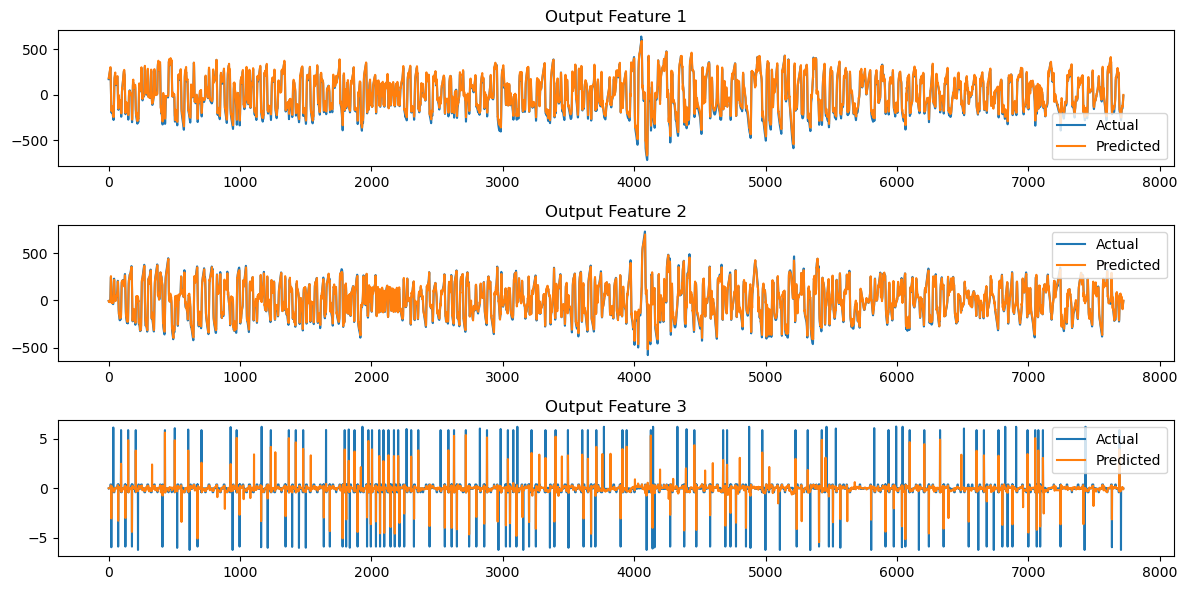

In [18]:
# 모델 평가 및 시각화

# 테스트 데이터 로드 및 예측
model.eval()
test_file_path = "data/data0.csv"  # 테스트할 데이터 파일 경로
test_data = pd.read_csv(test_file_path)

# 입력 및 출력 데이터 추출 및 정규화
X_test = test_data.values[:, x_features_csv].astype(np.float32)
y_test = test_data.values[:, y_features_csv].astype(np.float32)

# 정규화된 데이터를 사용하여 시퀀스 생성
X_test_seq, y_test_seq = create_sequences(scaler_x.transform(X_test), scaler_y.transform(y_test), TIME_STEP, STRIDE)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32)

# 예측 수행
y_pred = []
with torch.no_grad():
    for i in tqdm(range(len(X_test_seq)), desc="Predicting"):
        input_seq = X_test_tensor[i].unsqueeze(0)  # (1, seq_len, input_size)
        if cuda_available:
            input_seq = input_seq.cuda()
        pred = model(input_seq)
        pred = pred.cpu().numpy()
        # 역정규화
        pred_original = scaler_y.inverse_transform(pred)
        y_pred.append(pred_original.flatten())

y_pred = np.array(y_pred)
y_actual = scaler_y.inverse_transform(y_test_seq)

# RMSE 계산
rmse = np.sqrt(np.mean((y_pred - y_actual) ** 2))
print(f'Average RMSE on Test Data: {rmse:.4f}')

# 시각화
plt.figure(figsize=(12, 6))
for i in range(OUTPUT_SIZE):
    plt.subplot(OUTPUT_SIZE, 1, i + 1)
    plt.plot(y_actual[:, i], label='Actual')
    plt.plot(y_pred[:, i], label='Predicted')
    plt.title(f'Output Feature {i + 1}')
    plt.legend()
plt.tight_layout()
plt.show()

In [19]:
# ONNX 모델 내보내기

# ONNX 내보내기 전에 모델을 평가 모드로 설정
model.eval()

# 고정된 배치 사이즈 (1) 및 시퀀스 길이 사용
dummy_input = torch.randn(1, TIME_STEP, INPUT_SIZE)
if cuda_available:
    dummy_input = dummy_input.cuda()

# 모델을 CPU로 옮기고, 가중치 로드
model_cpu = LSTMModel(input_size=INPUT_SIZE, hidden_layer_size=HIDDEN_LAYER_SIZE, output_size=OUTPUT_SIZE,
                      dropout=0.3).cpu()
model_cpu.load_state_dict(torch.load(OUTPUT_FILENAME, map_location='cpu'))
model_cpu.eval()

# ONNX 내보내기
torch.onnx.export(
    model_cpu,
    dummy_input.cpu(),
    ONNX_PATH,
    verbose=True,
    input_names=['input'],
    output_names=['output'],
    # 고정된 배치 사이즈와 시퀀스 길이를 사용하므로 dynamic_axes 제거
    dynamic_axes={}
)

print("ONNX model exported successfully.")

ONNX model exported successfully.


C:\Users\dot_mario\anaconda3\envs\KartML_Python\lib\site-packages\torch\onnx\symbolic_opset9.py:4661: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
